In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from pandas.api.types import CategoricalDtype
from plotnine import ggplot, aes, geom_line, labs, theme, facet_wrap, scale_color_manual
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('../data/ground_station.csv')
df1 = pd.read_csv('../data/ground_station.csv')
df = pd.concat([df, df1], axis=0)
df = df.drop("Created_at",axis=1)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.sort_values('Timestamp').reset_index(drop=True)
df = df.set_index('Timestamp')

In [3]:
data_inicio = '2024-06-01'
data_fim = '2025-12-30'
df = df.loc[data_inicio:data_fim]
df = df.resample('h').mean()

In [4]:
df.describe()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
count,2.575000e+03,2.575000e+03,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000
mean,-1.197007e+02,4.985965e+01,17.057320,61.010399,0.004965,1.539439,207.885631,7845.636764,17.537231
std,1.421085e-14,7.102666e-15,7.107149,20.227491,0.034514,0.896225,84.528954,703.212065,8.197822
min,-1.197007e+02,4.985965e+01,2.581667,15.558333,0.000000,0.000000,0.000000,6533.333333,3.330000
25%,-1.197007e+02,4.985965e+01,11.855833,45.525000,0.000000,0.827500,150.500000,7240.000000,11.941667
50%,-1.197007e+02,4.985965e+01,16.121667,61.375000,0.000000,1.572500,191.083333,7861.333333,15.827500
75%,-1.197007e+02,4.985965e+01,21.311667,76.229167,0.000000,2.212500,298.666667,8472.666667,20.975000
max,-1.197007e+02,4.985965e+01,40.972500,99.933333,0.628650,4.745833,347.250000,8944.000000,51.923333


In [7]:
print(f"df.index.max(): {df.index.max()}")
print(f"df.index.min(): {df.index.min()}")

df.index.max(): 2025-05-12 16:00:00
df.index.min(): 2024-06-01 00:00:00


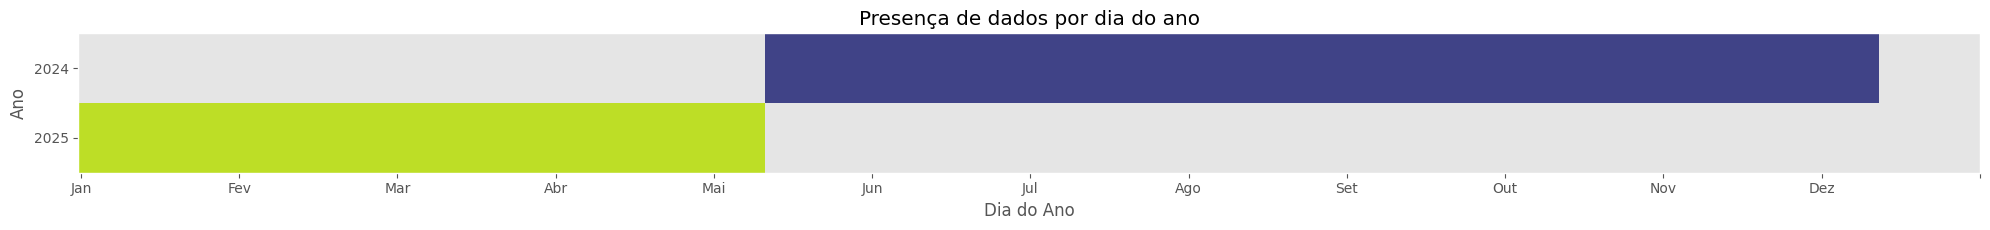

In [8]:
presence = pd.Series(1, index=df.index)
presence = presence.resample('D').max()

# Criar DataFrame com info de data
presence_df = presence.to_frame('present')
presence_df['year'] = presence_df.index.year
presence_df['day_of_year'] = presence_df.index.dayofyear

# Criar matriz de presença por ano x dia
matrix = presence_df.pivot(index='year', columns='day_of_year', values='present')

# Criar colormap com uma cor por ano
years = matrix.index
n_years = len(years)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, n_years))
cmap = mcolors.ListedColormap(colors)
data_colored = np.array([
    row * i if not np.all(np.isnan(row)) else np.nan
    for i, row in enumerate(matrix.values, start=1)
])

# Plotar
plt.figure(figsize=(20, n_years * 1.2))
plt.imshow(data_colored, aspect='auto', cmap=cmap, interpolation='none')
plt.xlabel('Dia do Ano')
plt.ylabel('Ano')
plt.title('Presença de dados por dia do ano')
plt.xticks(np.linspace(0, 365, 13), labels=['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez',''])
plt.yticks(ticks=np.arange(len(years)), labels=years)
plt.grid(False)
plt.tight_layout()
plt.show()

In [9]:
decomps = {}
residuals = pd.DataFrame(index=df.index)
for col in df.columns:
    if col == 'Timestamp':
        continue
    stl_res = STL(df[col], period=24, robust=True).fit()
    decomps[col] = stl_res
    residuals[col] = stl_res.resid

In [10]:
iso = IsolationForest(contamination='auto', random_state=42)
iso.fit(residuals)

IsolationForest(random_state=42)

In [11]:
flags = iso.predict(residuals)
is_multivariate_anomaly = pd.Series(flags == -1, index=residuals.index)
df['is_multivariate_anomaly'] = is_multivariate_anomaly
df.head()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature,is_multivariate_anomaly
Timestamp,,,,,,,,,,
2024-06-01 00:00:00,-119.591264,49.886552,22.742917,45.541667,0.0,1.692917,174.375000,9459.333333,18.383750,False
2024-06-01 01:00:00,-119.591264,49.886552,20.600417,51.254167,0.0,1.870000,218.125000,9412.666667,16.700833,False
2024-06-01 02:00:00,-119.591264,49.886552,16.647500,63.191667,0.0,1.901250,160.541667,9393.333333,14.904167,False
2024-06-01 03:00:00,-119.591264,49.886552,14.405833,67.770833,0.0,1.367083,119.375000,9385.333333,12.776250,False
2024-06-01 04:00:00,-119.591264,49.886552,12.257917,74.387500,0.0,1.441250,231.875000,9348.000000,10.842083,False


In [12]:
print('Foram encontrados {} outliers'.format(is_multivariate_anomaly.sum()))

Foram encontrados 283 outliers


In [13]:
df_clean = df.copy()
for col, stl_res in decomps.items():
    cleaned_series = df[col].copy()
    cleaned_series[is_multivariate_anomaly] = (stl_res.trend + stl_res.seasonal)[is_multivariate_anomaly]
    df_clean[col] = cleaned_series
df_clean.drop(columns=['is_multivariate_anomaly'], inplace=True)
df.drop(columns=['is_multivariate_anomaly'], inplace=True)
df_clean.head()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
Timestamp,,,,,,,,,
2024-06-01 00:00:00,-119.591264,49.886552,22.742917,45.541667,0.0,1.692917,174.375000,9459.333333,18.383750
2024-06-01 01:00:00,-119.591264,49.886552,20.600417,51.254167,0.0,1.870000,218.125000,9412.666667,16.700833
2024-06-01 02:00:00,-119.591264,49.886552,16.647500,63.191667,0.0,1.901250,160.541667,9393.333333,14.904167
2024-06-01 03:00:00,-119.591264,49.886552,14.405833,67.770833,0.0,1.367083,119.375000,9385.333333,12.776250
2024-06-01 04:00:00,-119.591264,49.886552,12.257917,74.387500,0.0,1.441250,231.875000,9348.000000,10.842083


In [63]:
print('--- Original ---')
print(df.describe())
print('--- Limpo ---')
print(df_clean.describe())

--- Original ---
         Longitude     Latitude  Temperature     Humidity  Precipitation  \
count  7846.000000  7846.000000  7846.000000  7846.000000    7846.000000   
mean   -119.523844    49.903123    12.801678    82.453987       0.063859   
std       0.064506     0.015855     6.483058    14.812617       2.614328   
min    -119.700698    49.859654    -1.575000    15.558333       0.000000   
25%    -119.591264    49.886552     8.525833    77.457292       0.000000   
50%    -119.481830    49.913450    11.365417    86.166667       0.000000   
75%    -119.481830    49.913450    16.816354    92.191667       0.000000   
max    -119.481830    49.913450    38.842500   100.000000     143.425329   

       Wind_Speed_kmh  Wind_Direction  Soil_Moisture  Soil_Temperature  
count     7846.000000     7846.000000    7846.000000       7846.000000  
mean         0.837815      100.996261    7496.105227         12.729076  
std          1.129882      106.487459    1323.206550          6.972079  
min   

In [2]:
orig_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='original')
)

clean_long = (
    df_clean
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='cleaned')
)

combined = pd.concat([orig_long, clean_long], ignore_index=True)
type_order = CategoricalDtype(['original', 'cleaned'], ordered=True)
combined['type'] = combined['type'].astype(type_order)

plot = (
    ggplot(combined, aes('Timestamp', 'value', color='type'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + scale_color_manual(values=['firebrick', 'navy'])
    + labs(
        title='Comparação: valores originais vs pós-tratamento',
        x='Timestamp',
        y='Valor',
        color='Série'
    )
    + theme(figure_size=(10, 6))
)

plot.show()

NameError: name 'df' is not defined

In [3]:
df = df_clean

NameError: name 'df_clean' is not defined

In [16]:
print(df.columns)

Index(['Longitude', 'Latitude', 'Temperature', 'Humidity', 'Precipitation',
       'Wind_Speed_kmh', 'Wind_Direction', 'Soil_Moisture',
       'Soil_Temperature'],
      dtype='object')


In [18]:
import xgboost as xgb
df_imputed = df.copy()
colunas_para_imputar = df.columns
df_imputed['hour'] = df_imputed.index.hour
df_imputed['dayofyear'] = df_imputed.index.dayofyear
df_imputed['dayofweek'] = df_imputed.index.dayofweek
df_imputed['month'] = df_imputed.index.month
df_imputed['year'] = df_imputed.index.year
features = [col for col in df_imputed.columns if col not in colunas_para_imputar]
print(f"Features para o modelo XGBoost: {features}")
for col_target in colunas_para_imputar:
    print(f"\nImputando coluna: {col_target}")

    # Separar dados para treino e dados com NaNs para predição
    df_train = df_imputed[df_imputed[col_target].notna()]
    df_predict = df_imputed[df_imputed[col_target].isna()]

    if df_predict.empty:
        print(f"Não há NaNs para imputar em {col_target}.")
        continue
    if df_train.empty:
        print(f"Não há dados de treino para {col_target}.")
        continue

    X_train = df_train[features]
    y_train = df_train[col_target]

    X_predict = df_predict[features]
    if X_train.isnull().any().any():
        print(f"Alerta: Encontrados NaNs nas features de TREINO para {col_target}. Preenchendo com a média.")
        for f_col in X_train.columns:
            if X_train[f_col].isnull().any():
                mean_val = X_train[f_col].mean()
                X_train.loc[:, f_col] = X_train[f_col].fillna(mean_val)
                if f_col in X_predict.columns:
                     X_predict.loc[:, f_col] = X_predict[f_col].fillna(mean_val)

    if X_predict.isnull().any().any():
         print(f"Alerta: Encontrados NaNs nas features de PREDIÇÃO para {col_target} que não foram preenchidos.")
    print(f"Shape X_train: {X_train.shape}, Shape y_train: {y_train.shape}")
    print(f"Shape X_predict: {X_predict.shape}")
    model = xgb.XGBRegressor(
        objective='reg:squarederror', # Para regressão
        n_estimators=100,             # Número de árvores
        learning_rate=0.1,            # Taxa de aprendizado
        max_depth=5,                  # Profundidade máxima da árvore
        subsample=0.8,                # Fração de amostras para treinar cada árvore
        colsample_bytree=0.8,         # Fração de features para treinar cada árvore
        random_state=42,
        # tree_method='hist' # Pode acelerar o treinamento para datasets grandes
    )
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict)
    df_imputed.loc[df_imputed[col_target].isna(), col_target] = predicted_values
    print(f"Total de NaNs em {col_target} após imputação: {df_imputed[col_target].isna().sum()}")
    df = df_imputed.drop(columns=['hour', 'dayofyear', 'dayofweek', 'month', 'year'], errors='ignore') # Remover colunas temporais auxiliares



Features para o modelo XGBoost: ['hour', 'dayofyear', 'dayofweek', 'month', 'year']

Imputando coluna: Longitude
Shape X_train: (7846, 5), Shape y_train: (7846,)
Shape X_predict: (451, 5)
Total de NaNs em Longitude após imputação: 0

Imputando coluna: Latitude
Shape X_train: (7846, 5), Shape y_train: (7846,)
Shape X_predict: (451, 5)
Total de NaNs em Latitude após imputação: 0

Imputando coluna: Temperature
Shape X_train: (7846, 5), Shape y_train: (7846,)
Shape X_predict: (451, 5)
Total de NaNs em Temperature após imputação: 0

Imputando coluna: Humidity
Shape X_train: (7846, 5), Shape y_train: (7846,)
Shape X_predict: (451, 5)
Total de NaNs em Humidity após imputação: 0

Imputando coluna: Precipitation
Shape X_train: (7846, 5), Shape y_train: (7846,)
Shape X_predict: (451, 5)
Total de NaNs em Precipitation após imputação: 0

Imputando coluna: Wind_Speed_kmh
Shape X_train: (7846, 5), Shape y_train: (7846,)
Shape X_predict: (451, 5)
Total de NaNs em Wind_Speed_kmh após imputação: 0

Imp

In [20]:
#Transformar Wind_Direction (porque ângulo 0° e 360° são "iguais")
df['Wind_Dir_Sin'] = np.sin(np.deg2rad(df['Wind_Direction']))
df['Wind_Dir_Cos'] = np.cos(np.deg2rad(df['Wind_Direction']))

df.drop(columns=['Wind_Direction'], inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 449.36it/s]


KeyboardInterrupt: 

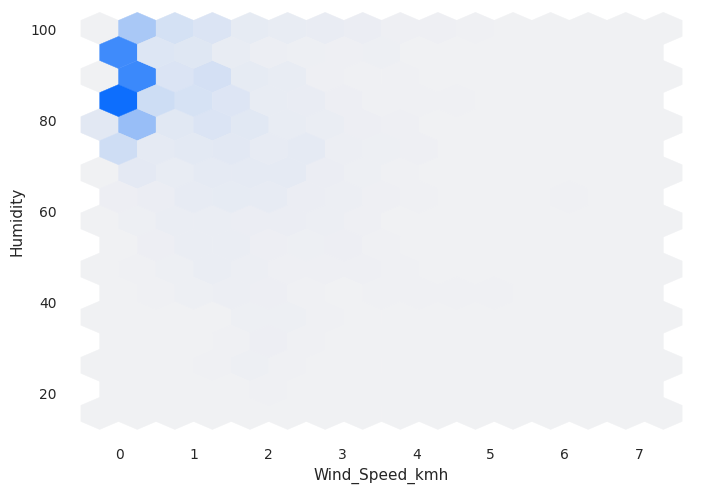

In [21]:
profile = ProfileReport(df, title='Profile Report')
profile.to_file('profile_report.html')

In [22]:
df.to_csv('../data/ground_station_clean.csv', index=True)